# A Graph Theory Approach to Algorithmic Trading Based on Millington and Niranjan (2020)

In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
import networkx as nx
import matplotlib.pyplot as plt
from scipy.linalg import expm
from sklearn.covariance import LedoitWolf

## Step 1: Get Official Holdings

In [3]:
def list_spy_holdings() -> pd.DataFrame:
    # Source: https://www.ssga.com/us/en/intermediary/etfs/spdr-sp-500-etf-trust-spy
    url = 'https://www.ssga.com/us/en/intermediary/library-content/products/fund-data/etfs/us/holdings-daily-us-en-spy.xlsx'

    # Read the excel file directly from the URL
    # Requires 'openpyxl'
    return pd.read_excel(url, engine='openpyxl', index_col='Ticker', skiprows=4).dropna()

print("Fetching official S&P 500 holdings from SSGA...")

try:
    spy_holdings = list_spy_holdings()

    # Convert index to list and filter out 'CASH_USD' or other non-equity placeholders
    tickers = [t for t in spy_holdings.index.tolist() if isinstance(t, str) and "-" not in t]

    # YFinance expects hyphens for classes (e.g., BRK-B) instead of dots (BRK.B)
    tickers = [t.replace('.', '-') for t in tickers]

    print(f"Successfully retrieved {len(tickers)} tickers.")
    dataset_name = "S&P 500 Network - Top 100 Correlations"

except:
    print(f"Error fetching S&P 500 holdings. Using sample set.")
    # Fallback to top tech stocks if fetch fails
    tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'TSLA']
    dataset_name = "Magnificent 7 Network"

Fetching official S&P 500 holdings from SSGA...
Successfully retrieved 503 tickers.


## Step 2: Data Download and Processing

This step is based on https://doi.org/10.1007/s41109-020-0251-z [1]. Personally, I disagree with their methodology:

*   Using today's S&P 500 list to simulate 20 years of history introduces survivorship bias because you are predicting the future: you are only including companies that were robust enough to survive until the present day. Using backward fill for data missing at the start is also cheating. It assumes you knew the price of a stock before it started trading. The fix is to build a new graph for every window based only on the S&P 500 constituents at the time. I haven't done this yet because it is extraordinarily painful to find a complete list of historical S&P companies without paying.
*   "Since **financial data is non stationary** we use a window of **300 days** and slide along this 30 days at a time to obtain a sample where **we can assume the data is stationary**, giving us 140 windows overall." Bruh



In [4]:
# Download adjusted close prices
data = yf.download(tickers, start="2016-01-01", end="2026-01-05", auto_adjust=True, progress=False)['Close']

# Drop columns (tickers) with more than 10% missing data
data = data.dropna(axis=1, thresh=int(data.shape[0] * 0.9))

# Fill remaining gaps (ffill with price from previous day, then bfill from first day traded if missing from start)
data = data.ffill().bfill()

log_returns = np.log(data / data.shift(1))
log_returns = log_returns.replace([np.inf, -np.inf], np.nan)
log_returns = log_returns.dropna()

In [5]:
window_size = 300
step_size = 30
normalized_windows = []
network_matrices = []

# Calculate total number of rows to loop through
n_samples = log_returns.shape[0]

print(f"Starting sliding window analysis on {n_samples} days of data...")

# Loop: Start at 0, stop before we run out of data, step by 30
for i in range(0, n_samples - window_size + 1, step_size):

    # Get rows i to i+300
    window_data = log_returns.iloc[i : i + window_size]
    window_mean = window_data.mean()
    window_std = window_data.std()

    # Handle division by zero (if a stock was flat for 300 days)
    # Replace 0 std with 1 to keep value as 0 (Mean) instead of NaN
    window_std = window_std.replace(0, 1)

    # Z-Score Normalization
    normalized_window = (window_data - window_mean) / window_std

    # Ledoit-Wolf Shrinkage
    lw = LedoitWolf()
    lw.fit(normalized_window)

    # The 'covariance_' attribute is the shrunk covariance matrix
    shrunk_cov = lw.covariance_

    # The 'precision_' attribute is the inverse (for partial correlation)
    shrunk_prec = lw.precision_

    # Calculate Standard Pearson Correlation
    pearson_corr = window_data.corr()

    # Convert Covariance to Correlation
    # C_ij = Sigma_ij / sqrt(Sigma_ii * Sigma_jj)
    d_cov = np.diag(shrunk_cov)
    denom_cov = np.sqrt(np.outer(d_cov, d_cov))
    shrunk_corr = shrunk_cov / denom_cov

    # Convert Precision to Partial Correlation
    # rho_ij = - p_ij / sqrt(p_ii * p_jj)
    d_prec = np.diag(shrunk_prec)
    denom_prec = np.sqrt(np.outer(d_prec, d_prec))
    partial_corr = -shrunk_prec / denom_prec
    np.fill_diagonal(partial_corr, 1.0)

    # Store Results
    window_tickers = window_data.columns
    res = {
        "start_date": window_data.index[0],
        "end_date": window_data.index[-1],
        "covariance": pd.DataFrame(shrunk_cov, index=window_tickers, columns=window_tickers),
        "pearson_corr": pd.DataFrame(pearson_corr, index=window_tickers, columns=window_tickers),
        "shrunk_corr": pd.DataFrame(shrunk_corr, index=window_tickers, columns=window_tickers),
        "partial_corr": pd.DataFrame(partial_corr, index=window_tickers, columns=window_tickers),
        "shrinkage_coeff": lw.shrinkage_
    }
    network_matrices.append(res)

print(f"Processed {len(network_matrices)} windows.")
print(f"Last Window Shrinkage Coefficient: {network_matrices[-1]['shrinkage_coeff']:.4f}")

Starting sliding window analysis on 2514 days of data...
Processed 74 windows.
Last Window Shrinkage Coefficient: 0.0954


## Step 3: Network Construction and Visualization

Following [1], we construct full weighted graphs using the above correlation matrices.

Plotting networks for window: 2016-01-05 to 2017-03-14


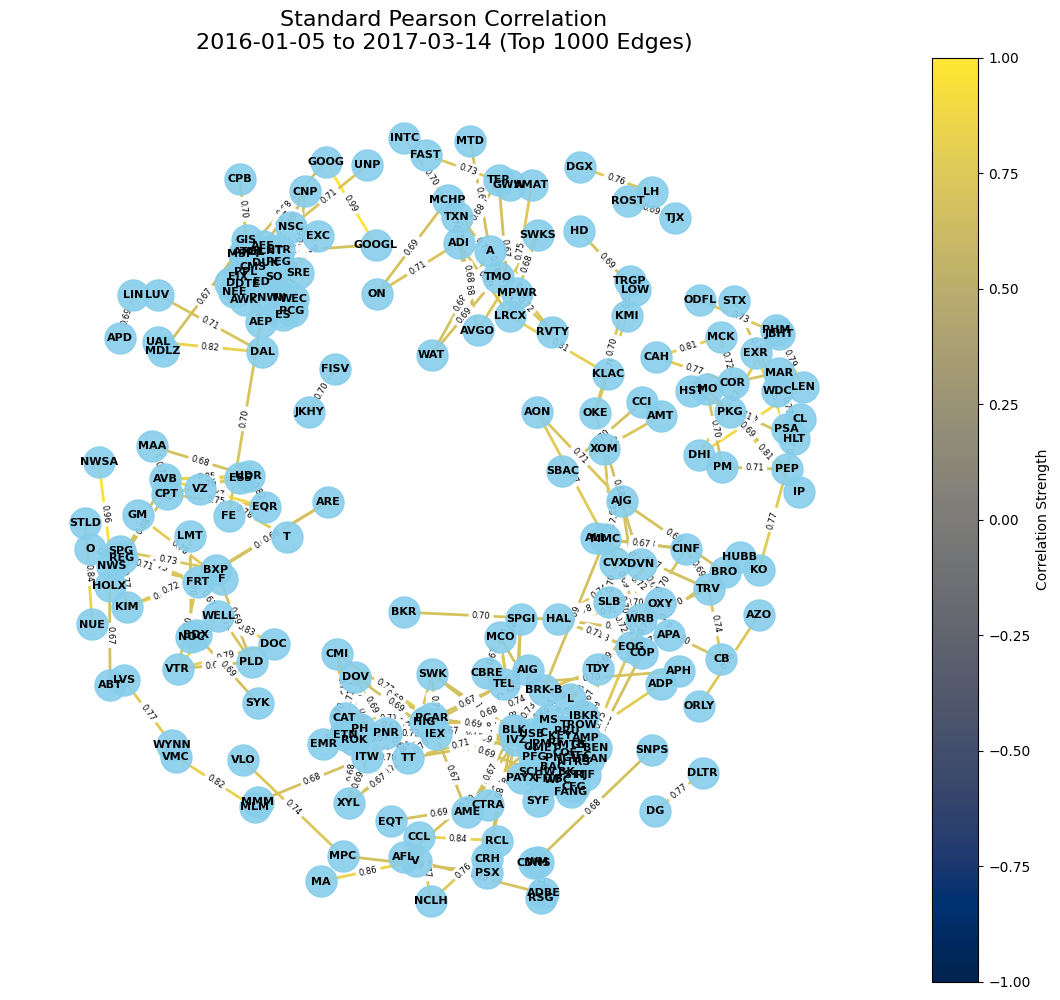

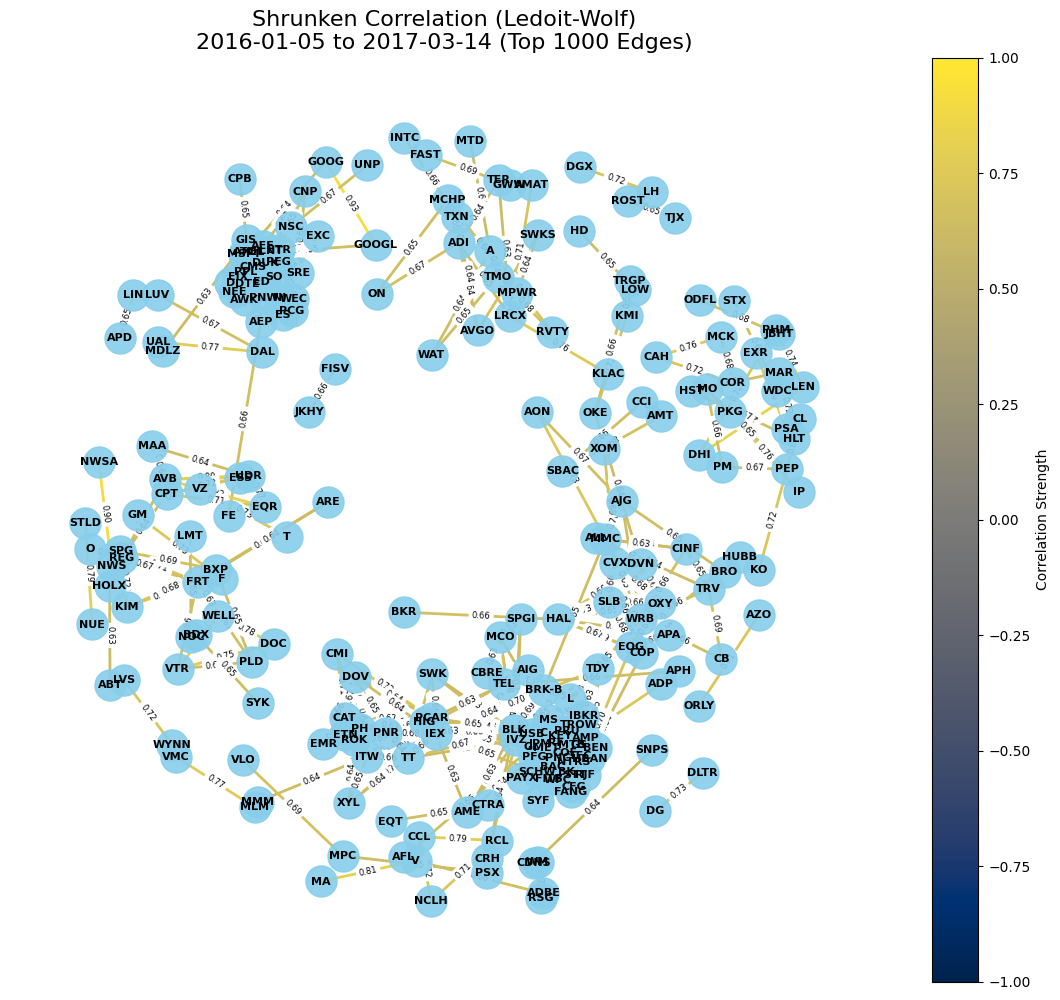

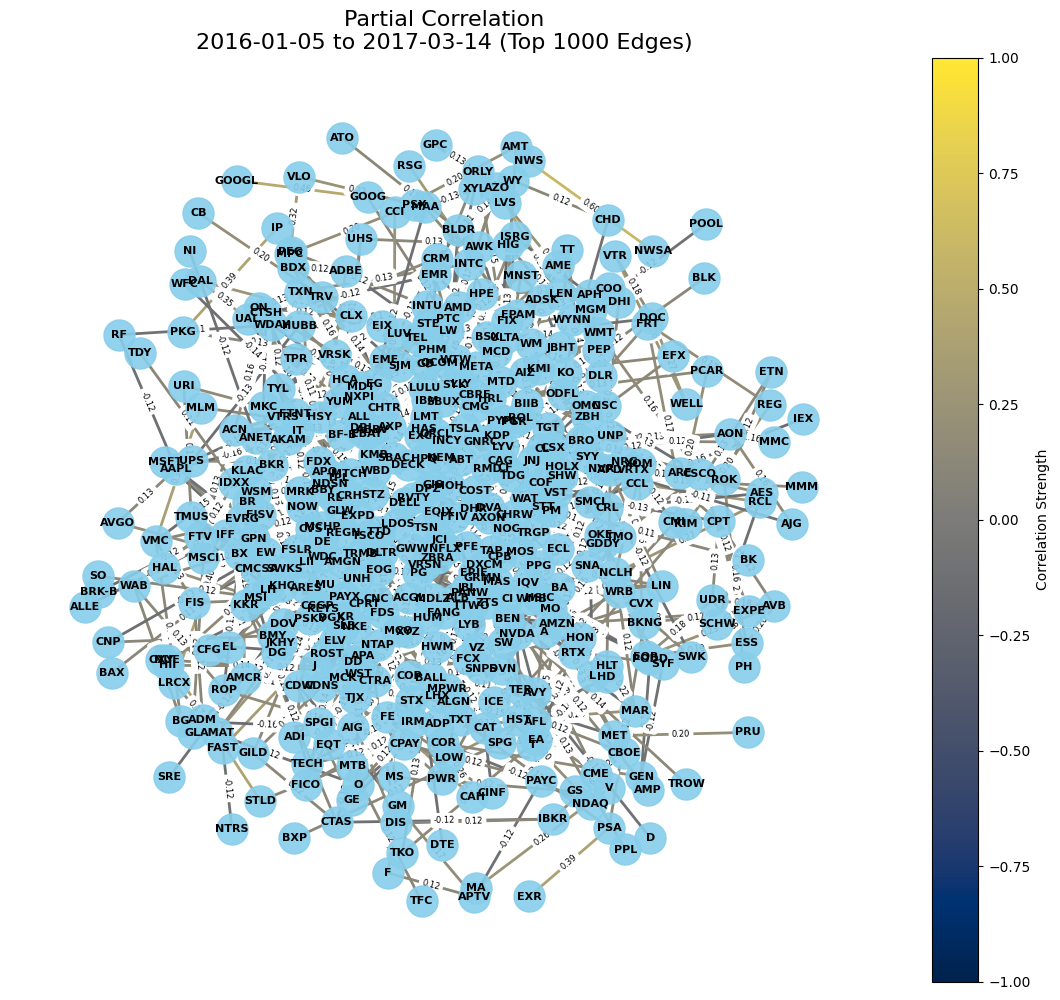

In [6]:
def plot_network(corr_matrix, title, top_n=1000):
    # Mask upper triangle to avoid duplicates and self-loops
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
    corr_masked = corr_matrix.where(mask)

    # Flatten to an edge list
    series_corr = corr_masked.stack()
    series_corr.index.names = ['Source', 'Target']
    edges = series_corr.reset_index()
    edges.columns = ['Source', 'Target', 'Weight']

    # Sort by strongest absolute correlations
    edges_sorted = edges.reindex(edges['Weight'].abs().sort_values(ascending=False).index)
    top_edges = edges_sorted.head(top_n)

    # Build Graph
    G = nx.from_pandas_edgelist(top_edges, 'Source', 'Target', ['Weight'])

    # Create a new figure
    plt.figure(figsize=(14, 12))

    # Spring layout tries to cluster highly correlated nodes closer together
    pos = nx.spring_layout(G, k=0.3, seed=42)

    # Draw Nodes
    nx.draw_networkx_nodes(G, pos, node_size=500, node_color='skyblue', alpha=0.9)

    # Draw Edges with Spectrum
    weights = [d['Weight'] for (u, v, d) in G.edges(data=True)]

    # Note: vmin/vmax set to -1 and 1 to keep the color scale consistent across plots
    edges_drawn = nx.draw_networkx_edges(
        G, pos,
        width=2,
        edge_color=weights,
        edge_cmap=plt.cm.cividis,
        edge_vmin=-1.0,
        edge_vmax=1.0
    )

    # Draw Node Labels
    nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold')

    # Draw Edge Labels (Weights) - Optional: can comment out if too cluttered
    edge_labels = {(u, v): f"{d['Weight']:.2f}" for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6, font_color='black')

    plt.title(f"{title} (Top {top_n} Edges)", fontsize=16)
    plt.axis('off')

    # Colorbar
    sm = plt.cm.ScalarMappable(cmap=plt.cm.cividis, norm=plt.Normalize(vmin=-1.0, vmax=1.0))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=plt.gca(), label='Correlation Strength')

# Execute Plots

# Get the data from the first window
first_window = network_matrices[0]
date_info = f"{first_window['start_date'].date()} to {first_window['end_date'].date()}"

print(f"Plotting networks for window: {date_info}")

# Standard Pearson
plot_network(first_window['pearson_corr'], f"Standard Pearson Correlation\n{date_info}")

# Shrunken Correlation
plot_network(first_window['shrunk_corr'], f"Shrunken Correlation (Ledoit-Wolf)\n{date_info}")

# Partial Correlation
plot_network(first_window['partial_corr'], f"Partial Correlation\n{date_info}")

plt.show()

## Step 4: Local Mispricings using Laplacian Diffusion

Based on https://doi.org/10.1007/s10114-004-0437-9 [2] and https://doi.org/10.1137/1.9781611972801 [3]. Because the full partial correlation matrix includes many weak and noisy edges that will dilute the signal, we choose to keep only the top $X\%$ of edges by absolute weight. Other methods to sparsify the network are also possible, such as a community-preserving filter, the graphical lasso, etc. Personally, I don't know enough statistics to tell you which one is best or if they even apply in this context. I'm probably just gonna implement as many as I can think of and then backtest to choose.

One problem that arises in the particular case of using a multiscale, community-preserving filter is the fact that partial correlation networks are less successful than correlation networks in uncovering sector clusters using a Louvain community detection algorithm [1]. The copium is that I am trying to detect mispricings in the stock market, not trying to recover stock market sectors. Sectors are public knowledge, which is already priced in. What remains after removing sector and market effects are the idiosyncratic, temporary, cross-sector relationships that might contain alpha.

In [7]:
# Thresholding
def threshold_matrix(corr_matrix, percentile=90):
    flat = corr_matrix.values.flatten()
    threshold = np.percentile(np.abs(flat), percentile)
    adj = corr_matrix.copy()
    adj[np.abs(adj) < threshold] = 0
    np.fill_diagonal(adj.values, 0)  # Remove self-loops
    return adj

# Community-preserving Filter THIS DOESNT WORK YET
# APPLY THE MODIFIED LOUVAIN DETECTION ALGORITHM TO THIS
def community_preserving_filter(corr_matrix, min_intra_community=0.1, min_inter_community=0.25):
    """
    1. Detect communities first
    2. Keep weaker edges within communities, stronger edges between
    """
    G = nx.from_numpy_array(np.abs(corr_matrix))
    communities = nx.algorithms.community.louvain_communities(G)

    adj = np.zeros_like(corr_matrix)
    for i, com_i in enumerate(communities):
        for j, com_j in enumerate(communities):
            threshold = min_intra_community if i == j else min_inter_community
            for node_a in com_i:
                for node_b in com_j:
                    if node_a != node_b and abs(corr_matrix[node_a, node_b]) > threshold:
                        adj[node_a, node_b] = corr_matrix[node_a, node_b]
    return adj

def community_preserving_filter(corr_matrix, min_intra_community=0.1, min_inter_community=0.3):
    """
    1. Detect communities on absolute correlations
    2. Keep weaker edges within communities, stronger edges between
    """
    # Convert to numpy for processing
    corr_values = corr_matrix.values
    n = len(corr_values)

    # Create graph from absolute correlations for community detection
    G = nx.from_numpy_array(np.abs(corr_values))

    # Detect communities (convert to list of lists)
    communities_list = list(nx.algorithms.community.louvain_communities(G, seed=42))

    # Create community mapping: node index -> community index
    node_to_community = {}
    for comm_idx, nodes in enumerate(communities_list):
        for node in nodes:
            node_to_community[node] = comm_idx

    # Apply filtering rules
    adj = np.zeros_like(corr_values)

    for i in range(n):
        for j in range(i+1, n):  # Only process upper triangle
            weight = corr_values[i, j]
            abs_weight = abs(weight)

            # Determine threshold based on communities
            if node_to_community[i] == node_to_community[j]:
                threshold = min_intra_community
            else:
                threshold = min_inter_community

            # Keep if above threshold
            if abs_weight > threshold:
                adj[i, j] = weight
                adj[j, i] = weight  # Symmetric

    # Convert back to DataFrame
    return pd.DataFrame(adj, index=corr_matrix.index, columns=corr_matrix.columns)

# Estimate residuals using the Signed Laplacian Diffusion (Heat Kernel)
def calculate_signed_diffusion_residuals(log_returns, adj_matrix, tau=0.5):
    """
    Args:
        log_returns (pd.Series): The vector of returns for one day.
        adj_matrix (pd.DataFrame): The Partial Correlation Matrix (A).
        tau (float): Diffusion time.
                     - Small tau (0.1) = weak smoothing (residuals ~ 0).
                     - Large tau (1.0+) = strong smoothing (residuals dominate).

    Returns:
        pd.Series: The residuals (Actual - Diffused Expected).
    """
    adj_matrix = threshold_matrix(adj_matrix, percentile=95)

    # Align Data
    valid_tickers = adj_matrix.index.intersection(log_returns.index)
    s_actual = log_returns[valid_tickers].values
    A = adj_matrix.loc[valid_tickers, valid_tickers].values

    # Construct Signed Laplacian (Ls = D_abs - A)
    degrees_abs = np.sum(np.abs(A), axis=1)
    D_abs = np.diag(degrees_abs)
    Ls = D_abs - A

    # Compute Heat Kernel: e^(-tau * Ls)
    kernel = expm(-tau * Ls)

    # Diffuse
    s_expected = kernel @ s_actual

    # Calculate Residual
    residuals = s_actual - s_expected

    return pd.Series(residuals, index=valid_tickers)

# List Mispricings
last_window = network_matrices[-1]
last_day_returns = log_returns.iloc[-1]

# Standard Pearson
pearson_corr = last_window['pearson_corr']
pearson_res = calculate_signed_diffusion_residuals(last_day_returns, pearson_corr, tau=0.5)

print("--- Short Candidates (Standard Pearson Correlation) ---")
print(pearson_res[pearson_res > 0].sort_values(ascending=False).head(5))
print("\n--- Long Candidates (Standard Pearson Correlation) ---")
print(pearson_res[pearson_res < 0].sort_values().head(5))

# Shrunken Correlation
shrunk_corr = last_window['shrunk_corr']
shrunk_res = calculate_signed_diffusion_residuals(last_day_returns, shrunk_corr, tau=0.5)

print("\n--- Short Candidates (Shrunken Correlation) ---")
print(shrunk_res[shrunk_res > 0].sort_values(ascending=False).head(5))
print("\n--- Long Candidates (Shrunken Correlation) ---")
print(shrunk_res[shrunk_res < 0].sort_values().head(5))

# Partial Correlation
partial_corr = last_window['partial_corr']
partial_res = calculate_signed_diffusion_residuals(last_day_returns, partial_corr, tau=0.5)

print("\n--- Short Candidates (Partial Correlation) ---")
print(partial_res[partial_res > 0].sort_values(ascending=False).head(5))
print("\n--- Long Candidates (Partial Correlation) ---")
print(partial_res[partial_res < 0].sort_values().head(5))

--- Short Candidates (Standard Pearson Correlation) ---
Ticker
MU      0.083434
WDC     0.065419
LRCX    0.063184
FIX     0.054012
TER     0.053049
dtype: float64

--- Long Candidates (Standard Pearson Correlation) ---
Ticker
GPN    -0.035605
CDW    -0.033914
MCO    -0.032865
PAYX   -0.032374
CTSH   -0.029406
dtype: float64

--- Short Candidates (Shrunken Correlation) ---
Ticker
MU      0.082482
WDC     0.063627
LRCX    0.062579
FIX     0.052893
TER     0.051779
dtype: float64

--- Long Candidates (Shrunken Correlation) ---
Ticker
GPN    -0.035625
CDW    -0.034081
MCO    -0.032748
PAYX   -0.031275
CTSH   -0.029343
dtype: float64

--- Short Candidates (Partial Correlation) ---
Ticker
MU      0.052567
INTC    0.051145
TER     0.044910
SMCI    0.042563
FSLR    0.040652
dtype: float64

--- Long Candidates (Partial Correlation) ---
Ticker
IT     -0.047306
INTU   -0.036086
GDDY   -0.032481
ADBE   -0.031772
WDAY   -0.031669
dtype: float64
